# SHRED-ROM Tutorial on Double Gyre Flow
**Authors:** Stefano Riva and Matteo Tomasetto

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MSmKFJPf0B81iAN2hjU-3IvFgimUBIc9)

The double gyre flow is a time-dependent model for two counter-rotating vortices (gyres) in a rectangular domain. When time is introduced via a periodic perturbation, the central dividing line between the two gyres oscillates left and right, creating a time-varying velocity field that can lead to chaotic particle trajectories. The velocity field $\mathbf{v} = [u, v]^T$ in the domain $[0, L_x] \times [0, L_y]$ and in the time interval $[0, T]$ is given by


$$
\begin{align}
u(x, y, t) &= -\pi I \sin\left( \pi f(x, t) \right) \cos\left( \pi y \right)
\\
v(x, y, t) &= \pi I \cos\left( \pi f(x, t) \right) \sin\left( \pi y \right) \frac{\partial f}{\partial x}
\end{align}
$$

\
where $I$ is the intensity parameter, $f(x, t) = \epsilon \sin(\omega t) x^2 + (1 - 2\epsilon \sin(\omega t)) x $, $\epsilon$ and $\omega$ are the perturbation amplitude and the frequency of the oscillation, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

# PYSHRED
from pyshred import DataManager, SHRED, SHREDEngine, LSTM_Forecaster

# IMPORT LIBRARIES
import torch
import numpy as np
import matplotlib.pyplot as plt

c:\Tools\MiniConda\envs\datasci\lib\site-packages\pysindy\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


A function to compute the velocity components $u$ and $v$ is provided below.

In [2]:
# DEFINE THE SYSTEM SOLVER

def double_gyre_flow(amplitude, frequency, x, y, t):
    '''
    Solve the double gyre flow problem

    Inputs
        amplitude                   (`float`)
        frequency                   (`float`)
        horizontal discretization   (`np.array[float]`, shape: (ny,))
        vertical discretization     (`np.array[float]`, shape: (nx,))
        time vector                 (`np.array[float]`, shape: (ntimes,))

    Output
        horizontal velocity matrix  (`np.array[float]`, shape: (ntimes, nx * ny)
        vertical velocity matrix    (`np.array[float]`, shape: (ntimes, nx * ny)
    '''

    xgrid, ygrid = np.meshgrid(x, y)         # spatial grid

    u = np.zeros((len(t), len(x), len(y)))   # horizontal velocity
    v = np.zeros((len(t), len(x), len(y)))   # vertical velocity

    intensity = 0.1   # intensity parameter

    f = lambda x,t: amplitude * np.sin(frequency * t) * x**2 + x - 2 * amplitude * np.sin(frequency * t) * x

    # compute solution
    for i in range(len(t)):
      u[i] = (-np.pi * intensity * np.sin(np.pi * f(xgrid, t[i])) * np.cos(np.pi * ygrid)).T
      v[i] = (np.pi * intensity * np.cos(np.pi * f(xgrid, t[i])) * np.sin(np.pi * ygrid) * (2 * amplitude * np.sin(frequency * t[i]) * xgrid + 1.0 - 2 * amplitude * np.sin(frequency * t[i]))).T

    return u, v

Let us look at an example of the double gyre flow with the following parameters:
- Amplitude $\epsilon = 0.25$
- Frequency $\omega = 5$

In [3]:
# SOLVE THE SYSTEM FOR A FIXED TRANSPORT TERM

amplitude = 0.25    # amplitude
frequency = 5.0     # frequency

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.05
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

u, v = double_gyre_flow(amplitude, frequency, x, y, t)

Let us plot the solution, in terms of the vorticity field $w = -\partial u / \partial y + \partial v / \partial x$

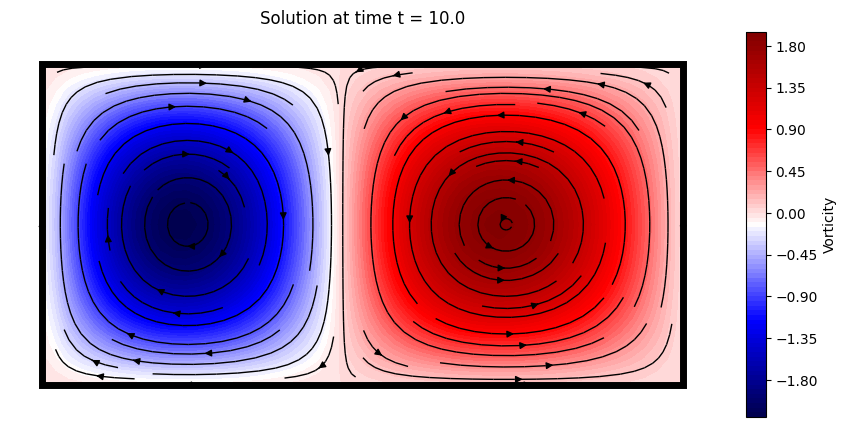

In [4]:
# SOLUTION VISUALIZATION

from ipywidgets import interact, FloatSlider
import matplotlib.patches as patches

def vorticity(u, v):
    dx = Lx / nx
    dy = Ly / ny
    du_dy = np.gradient(u, dy, axis = 1)
    dv_dx = np.gradient(v, dx, axis = 0)
    return dv_dx - du_dy

def plot_solution(time):

    which_time = (np.abs(t - time)).argmin()
    offset = 0.1

    plt.figure(figsize = (10,5))
    cont = plt.contourf(x, y, vorticity(u[which_time], v[which_time]).T, cmap = 'seismic', levels = 100)
    plt.colorbar(cont, label='Vorticity', orientation='vertical', pad=0.04, aspect=20, fraction=0.05)
    plt.streamplot(x, y, u[which_time].T, v[which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Solution at time t = {round(time, 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))


# interact(plot_solution, time = FloatSlider(value = t[0], min = t[0], max = t[-1], step = (t[1]-t[0]), description='time', layout={'width': '400px', 'height': '50px'}))
plot_solution(t[-1])

Let us generate the snapshots by sampling the velocity field for parameters $\epsilon\in [0,0.5]$, $\omega \in [0.5, 2\pi]$ (randomly sampled).

In [5]:
# DATA GENERATION

amplitude_range = np.array([0.0, 0.5])
frequency_range = np.array([0.5, 2*np.pi])

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.05
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

# training data generation
ntrajectories = 100
U = np.zeros((ntrajectories, ntimes, nx, ny))
V = np.zeros((ntrajectories, ntimes, nx, ny))

parameters = np.zeros((ntrajectories, ntimes, 2))  # store amplitude and frequency

for i in range(ntrajectories):
  amplitude = (amplitude_range[1] - amplitude_range[0]) * np.random.rand() + amplitude_range[0]
  frequency = (frequency_range[1] - frequency_range[0]) * np.random.rand() + frequency_range[0]
  U[i], V[i] = double_gyre_flow(amplitude, frequency, x, y, t)

  parameters[i, :, 0] = amplitude
  parameters[i, :, 1] = frequency

Here a trajectory is visualized

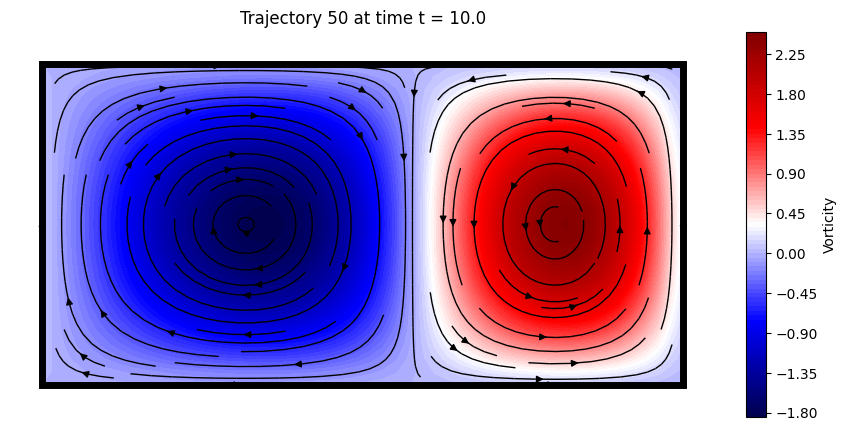

In [6]:
# DATA VISUALIZATION

from ipywidgets import interact, IntSlider

def plot_data(which_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (10,5))
    cont = plt.contourf(x, y, vorticity(U[which_trajectory, which_time], V[which_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.colorbar(cont, label='Vorticity', orientation='vertical', pad=0.04, aspect=20, fraction=0.05)
    plt.streamplot(x, y, U[which_trajectory, which_time].T, V[which_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Trajectory {which_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

# interact(plot_data, which_trajectory = IntSlider(min = 0, max = ntrajectories - 1, step = 1, description='Trajectory'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));
plot_data(50, -1)

## **SHallow REcurrent Decoder networks-based Reduced Order Modeling (SHRED-ROM)**

Let us assume to have three sensors in the domain measuring the horizontal velocity $u(x_s,y_s,t;\epsilon, \omega)$ over time. *SHRED-ROM* aims to reconstruct the temporal evolution of the entire velocity $\mathbf{v}(x,y,t;\epsilon, \omega) = [u(x,y,t;\epsilon, \omega), v(x,y,t;\epsilon, \omega)]^T$ starting from the limited sensor measurements available. In general, *SHRED-ROM* combines a recurrent neural network (LSTM), which encodes the temporal history of sensor values in multiple parametric regimes, and a shallow decoder, which projects the LSTM prediction to the (possibly high-dimensional) state dimension. Note that, to enhance computational efficiency and memory usage, dimensionality reduction strategies (such as, e.g., POD) may be considered to compress the training snapshots.

Two different compression strategies are available in this tutorial:
1. **POD**: Proper Orthogonal Decomposition, which computes the low-rank approximation of the training snapshots.
2. **Fourier**: Fourier decomposition, which computes the Fourier coefficients of the training snapshots.

In [7]:
U = U.reshape(ntrajectories, ntimes, nstate)
V = V.reshape(ntrajectories, ntimes, nstate)

### POD-based compressive training
The `ParametricDataManager` is initialized

In [8]:
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine

# Initialize ParametricSHREDDataManager
manager_pod = ParametricDataManager(
    lags = 25,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

import warnings
warnings.filterwarnings("ignore")

Let us add the different fields, the component $u$ is the one we want to reconstruct, while $v$ is indirectly reconstructed. The parameters $\epsilon$ and $\omega$ are included as output of the SHRED architecture.

In [9]:
manager_pod.add_data(
    data=U,        # 3D array (parametric_trajectories, timesteps, field_dim)
    id="U",        # Unique identifier for the dataset
    random=3,      # Randomly select 3 sensor locations
    compress=4     # Spatial compression
)

## Since no random selection is specified for the second dataset, no measurement locations will be selected
manager_pod.add_data(
    data=V,         
    id="V",        
    compress=4     
)

## Add parameters to the manager
manager_pod.add_data(
    data=parameters,
    id='mu',
    compress=False,
)

If you want to add noise to the measurements (zero-mean Gaussian), it can added as follows:

In [10]:
manager_pod.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,U,0,stationary (random),"(475,)"
1,U,1,stationary (random),"(944,)"
2,U,2,stationary (random),"(1163,)"


In [11]:
noise_std = 0.005
random_noise = np.random.normal(loc=0, scale=noise_std, size=manager_pod.sensor_measurements_df.shape)

manager_pod.sensor_measurements_df += random_noise

Let us prepare the data by splitting them into train, valid and test sets.

In [12]:
train_dataset, val_dataset, test_dataset = manager_pod.prepare()

**Definition of the SHRED architecture**

In [13]:
shred_pod = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster=None
)

Let us fit the SHRED architecture

In [14]:
val_errors_shredpod = shred_pod.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    patience=50,
    verbose=True,
)

Fitting SHRED...
Epoch 1: Average training loss = 0.053392
Validation MSE (epoch 1): 0.043212
Epoch 2: Average training loss = 0.032544
Validation MSE (epoch 2): 0.024448
Epoch 3: Average training loss = 0.023836
Validation MSE (epoch 3): 0.020105
Epoch 4: Average training loss = 0.020569
Validation MSE (epoch 4): 0.017764
Epoch 5: Average training loss = 0.020235
Validation MSE (epoch 5): 0.016091
Epoch 6: Average training loss = 0.017805
Validation MSE (epoch 6): 0.015052
Epoch 7: Average training loss = 0.016603
Validation MSE (epoch 7): 0.014485
Epoch 8: Average training loss = 0.015684
Validation MSE (epoch 8): 0.013516
Epoch 9: Average training loss = 0.014828
Validation MSE (epoch 9): 0.012803
Epoch 10: Average training loss = 0.014153
Validation MSE (epoch 10): 0.012308
Epoch 11: Average training loss = 0.012916
Validation MSE (epoch 11): 0.011462
Epoch 12: Average training loss = 0.012554
Validation MSE (epoch 12): 0.011643
Epoch 13: Average training loss = 0.012317
Validation

Here the validation loss is plotted

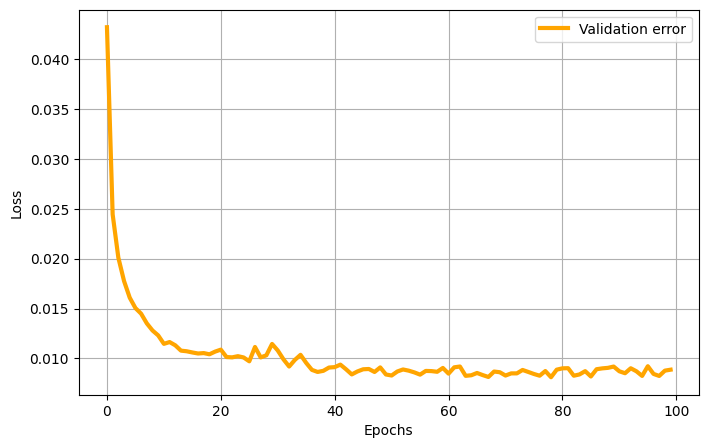

In [15]:
plt.figure(figsize = (8,5))
plt.plot(val_errors_shredpod, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

Let us evaluate the SHRED model on the different sets

In [16]:
print(f"Train MSE: {shred_pod.evaluate(dataset=train_dataset):.3f}")
print(f"Val   MSE: {shred_pod.evaluate(dataset=val_dataset):.3f}")
print(f"Test  MSE: {shred_pod.evaluate(dataset=test_dataset):.3f}")

Train MSE: 0.008
Val   MSE: 0.009
Test  MSE: 0.007


Let us check the reconstruction of the POD coefficients

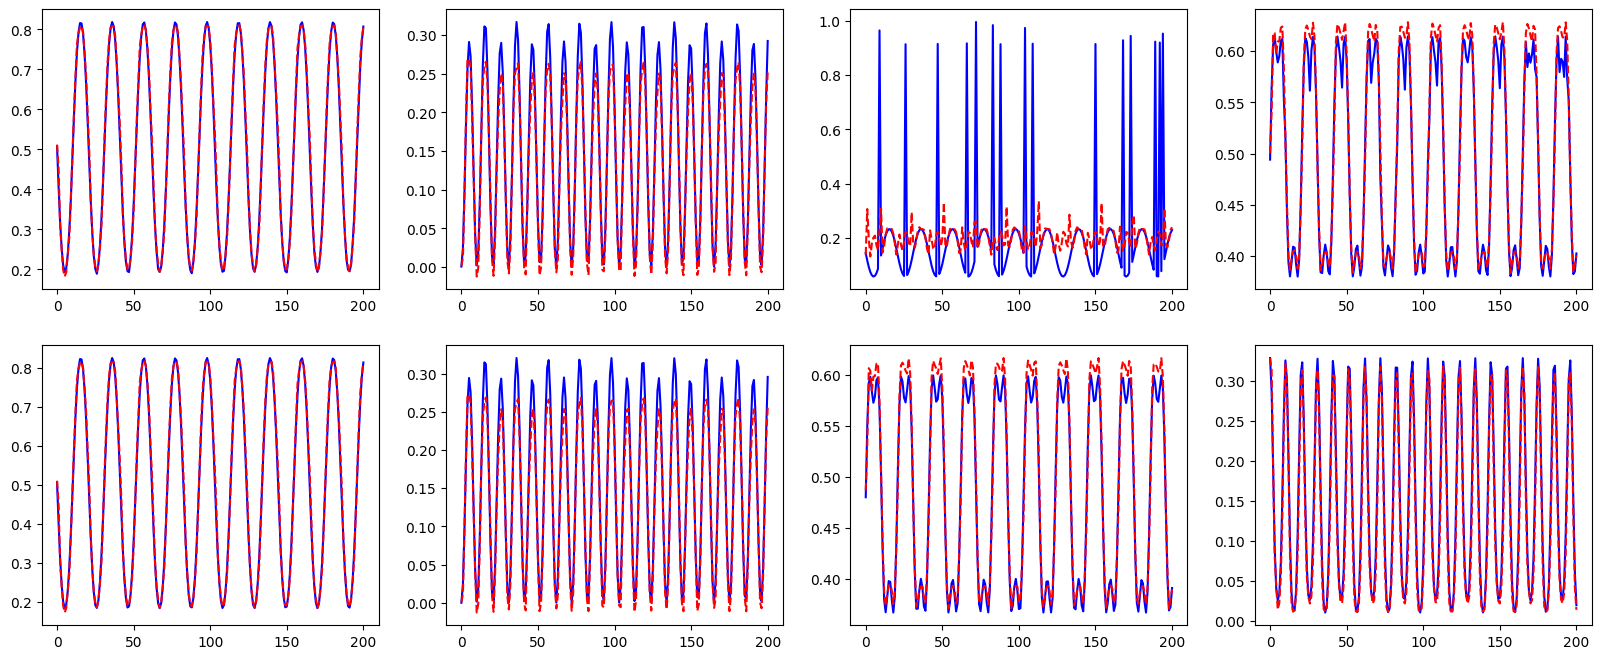

In [17]:
which_param = 0  # Index of the parameter to visualize

fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i in range(4):
    axs[0, i].plot(test_dataset.Y[ntimes * which_param:ntimes * (which_param + 1), i].cpu().numpy(), 'b', label='True U')
    axs[0, i].plot(shred_pod(test_dataset.X)[ntimes * which_param:ntimes * (which_param + 1), i].cpu().detach().numpy(), 'r--', label='True U')

    axs[1, i].plot(test_dataset.Y[ntimes * which_param:ntimes * (which_param + 1), i + 4].cpu().numpy(), 'b', label='True V')
    axs[1, i].plot(shred_pod(test_dataset.X)[ntimes * which_param:ntimes * (which_param + 1), i + 4].cpu().detach().numpy(), 'r--', label='True V')

Let us check the reconstruction of the double gyre flow

### Fourier-based compressive training

In [18]:
freq_cutoff = 0.05

freq_x = np.fft.fftfreq(nx)
freq_y = np.fft.fftfreq(ny)
freq_x_grid, freq_y_grid = np.meshgrid(freq_x, freq_y)
mask_x = np.abs(freq_x_grid.T) <= freq_cutoff

# Transform the data to frequency domain - U
U_fft = np.fft.fft2(U.reshape(ntrajectories, ntimes, nx, ny), axes = (-2, -1))
U_fft[:,:,~mask_x] = 0
U_proj = U_fft[:,:,mask_x]
U_proj_real = np.real(U_proj)
U_proj_imag = np.imag(U_proj)

Fourier_modes_x = U_proj.shape[-1]

# Transform the data to frequency domain - V
mask_y = np.abs(freq_y_grid.T) <= freq_cutoff
V_fft = np.fft.fft2(V.reshape(ntrajectories, ntimes, nx, ny), axes = (-2, -1))
V_fft[:,:,~mask_y] = 0
V_proj = V_fft[:,:,mask_y]
V_proj_real = np.real(V_proj)
V_proj_imag = np.imag(V_proj)

Fourier_modes_y = V_proj.shape[-1]

Let us plot the projected and reconstructed velocity fields

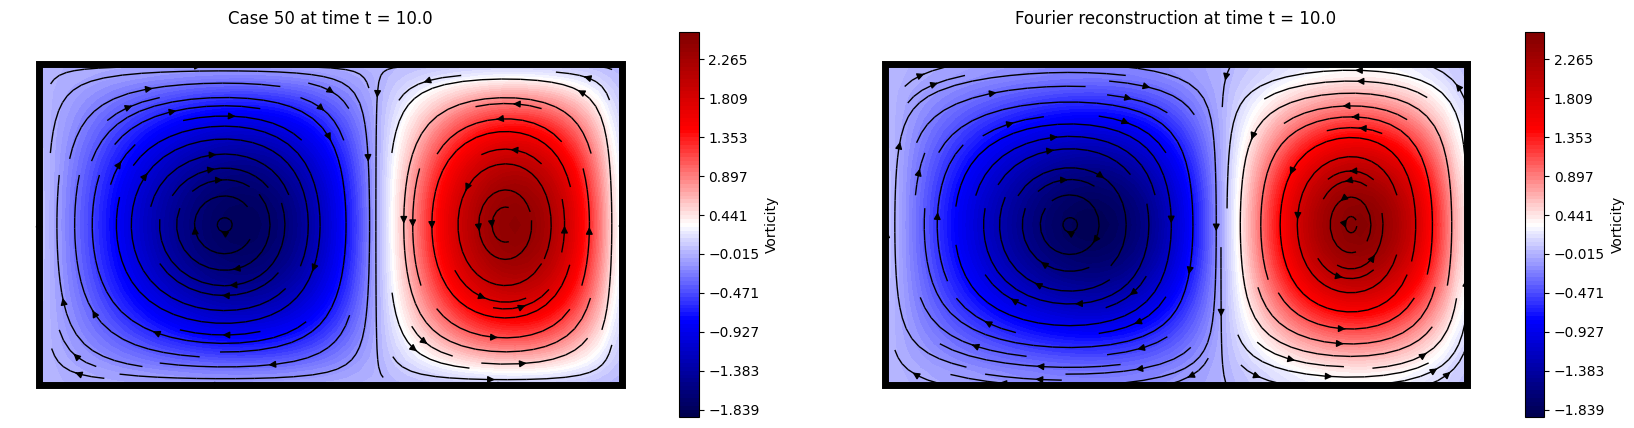

In [19]:
U_recons = np.fft.ifft2(U_fft).real
V_recons = np.fft.ifft2(V_fft).real

def plot_fourier_data(which_test_trajectory, which_time):

    offset = 0.1

    _min = vorticity(U[which_test_trajectory, which_time].reshape(nx, ny),  V[which_test_trajectory, which_time].reshape(nx, ny)).min()
    _max = vorticity(U[which_test_trajectory, which_time].reshape(nx, ny),  V[which_test_trajectory, which_time].reshape(nx, ny)).max()

    levels = np.linspace(_min, _max, 100) * 1.05

    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    cont = plt.contourf(x, y, vorticity(U[which_test_trajectory, which_time].reshape(nx, ny),  V[which_test_trajectory, which_time].reshape(nx, ny)).T, cmap = 'seismic', levels = levels)
    plt.streamplot(x, y, U[which_test_trajectory, which_time].reshape(nx, ny).T, V[which_test_trajectory, which_time].reshape(nx, ny).T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    plt.colorbar(cont, label='Vorticity', orientation='vertical', pad=0.04, aspect=20, fraction=0.05)

    plt.subplot(1, 2, 2)
    cont = plt.contourf(x, y, vorticity(U_recons[which_test_trajectory, which_time].reshape(nx, ny),  V_recons[which_test_trajectory, which_time].reshape(nx, ny)).T, cmap = 'seismic', levels = levels)
    plt.streamplot(x, y, U_recons[which_test_trajectory, which_time].reshape(nx, ny).T, V_recons[which_test_trajectory, which_time].reshape(nx, ny).T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Fourier reconstruction at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    plt.colorbar(cont, label='Vorticity', orientation='vertical', pad=0.04, aspect=20, fraction=0.05)

# interact(plot_fourier_data, which_test_trajectory = IntSlider(min = 0, max = ntrajectories - 1, step = 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

plot_fourier_data(50, -1)

Let us compute the measurement field from $u$ using the same input positions as before

In [20]:
sens_locs = [manager_pod.sensor_summary_df['loc/traj'][i][0] for i in range(len(manager_pod.sensor_summary_df))]

measurements = U[:, :, sens_locs]

# Add noise to the measurements
measurements += np.random.normal(loc=0, scale=noise_std, size=measurements.shape)

Let us initialize the `ParametricDataManager` for Fourier-based training

In [21]:
manager_fourier = ParametricDataManager(
    lags = 25,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1
)

Let us add the different fields, the component $u$ is the one we want to reconstruct, while $v$ is indirectly reconstructed. The parameters $\epsilon$ and $\omega$ are included as output of the SHRED architecture.

In [22]:
# Real and imaginary parts have to be added separately
manager_fourier.add_data(
    data=U_proj_real,        
    id="Ufft_real",        
    measurements=measurements,  # Use the measurements with noise already computed
    compress=False
)

manager_fourier.add_data(
    data=U_proj_imag,        
    id="Ufft_imag",        
    compress=False
)

# Add the second dataset (V) in the same way
manager_fourier.add_data(
    data=V_proj_real,        
    id="Vfft_real",        
    compress=False
)

manager_fourier.add_data(
    data=V_proj_imag,        
    id="Vfft_imag",        
    compress=False
)

## Add parameters to the manager
manager_fourier.add_data(
    data=parameters,
    id='mu',
    compress=False,
)

Let us prepare the data by splitting them into train, valid and test sets.

In [23]:
train_dataset, val_dataset, test_dataset= manager_fourier.prepare()

**Definition of the SHRED architecture**

In [24]:
shred_fourier = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster=None
)

Let us fit the SHRED architecture

In [25]:
val_errors_shredfourier = shred_fourier.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    patience=50,
    verbose=True,
)

Fitting SHRED...
Epoch 1: Average training loss = 0.053214
Validation MSE (epoch 1): 0.014368
Epoch 2: Average training loss = 0.009338
Validation MSE (epoch 2): 0.002854
Epoch 3: Average training loss = 0.003565
Validation MSE (epoch 3): 0.002174
Epoch 4: Average training loss = 0.002810
Validation MSE (epoch 4): 0.002424
Epoch 5: Average training loss = 0.002591
Validation MSE (epoch 5): 0.002467
Epoch 6: Average training loss = 0.002366
Validation MSE (epoch 6): 0.002638
Epoch 7: Average training loss = 0.002098
Validation MSE (epoch 7): 0.002637
Epoch 8: Average training loss = 0.002073
Validation MSE (epoch 8): 0.002461
Epoch 9: Average training loss = 0.001950
Validation MSE (epoch 9): 0.002186
Epoch 10: Average training loss = 0.001827
Validation MSE (epoch 10): 0.001497
Epoch 11: Average training loss = 0.001761
Validation MSE (epoch 11): 0.002201
Epoch 12: Average training loss = 0.001868
Validation MSE (epoch 12): 0.001741
Epoch 13: Average training loss = 0.001829
Validation

Here the validation loss is plotted

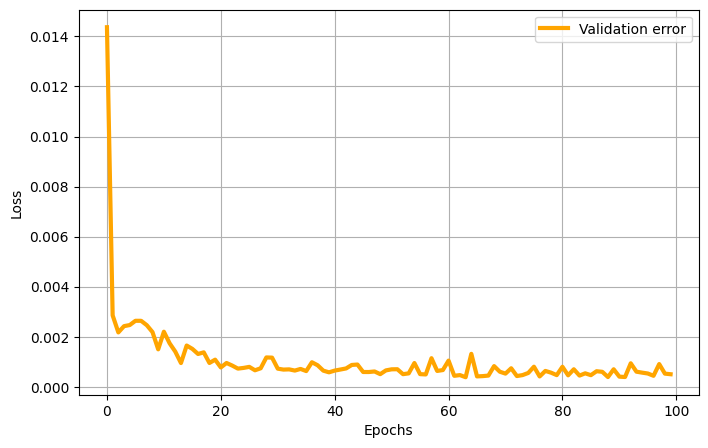

In [26]:
plt.figure(figsize = (8,5))
plt.plot(val_errors_shredfourier, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

Let us evaluate the SHRED model on the different sets

In [27]:
print(f"Train MSE: {shred_fourier.evaluate(dataset=train_dataset):.5f}")
print(f"Val   MSE: {shred_fourier.evaluate(dataset=val_dataset):.5f}")
print(f"Test  MSE: {shred_fourier.evaluate(dataset=test_dataset):.5f}")

Train MSE: 0.00050
Val   MSE: 0.00050
Test  MSE: 0.00054


Let us check the reconstruction of the Fourier coefficients

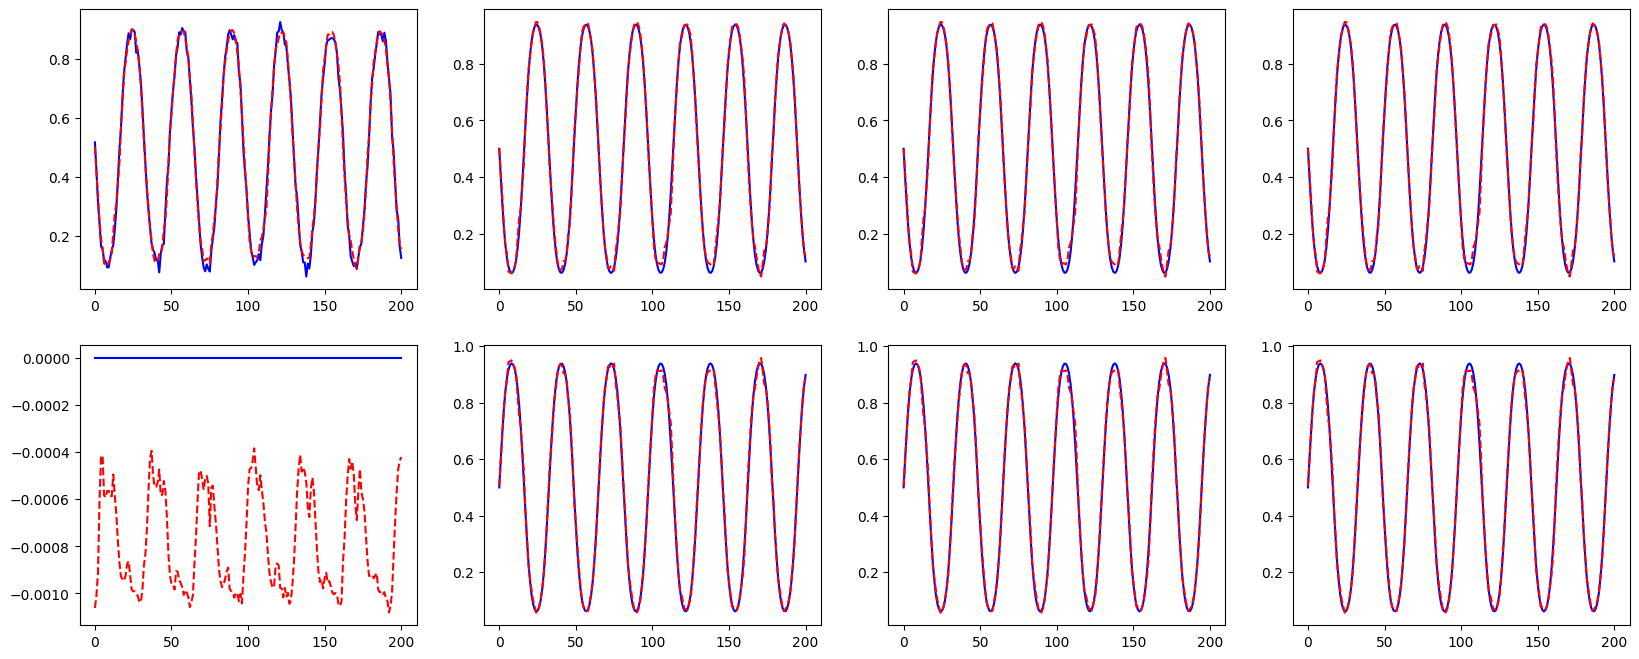

In [28]:
which_param = 5  # Index of the parameter to visualize

fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i in range(4):
    axs[0, i].plot(test_dataset.Y[ntimes * which_param:ntimes * (which_param + 1), i].cpu().numpy(), 'b', label='True U')
    axs[0, i].plot(shred_fourier(test_dataset.X)[ntimes * which_param:ntimes * (which_param + 1), i].cpu().detach().numpy(), 'r--', label='True U')

    axs[1, i].plot(test_dataset.Y[ntimes * which_param:ntimes * (which_param + 1), i + 125].cpu().numpy(), 'b', label='True V')
    axs[1, i].plot(shred_fourier(test_dataset.X)[ntimes * which_param:ntimes * (which_param + 1), i + 125].cpu().detach().numpy(), 'r--', label='True V')

### Comparison of POD and Fourier-based training

Let us define the different engines for evaluations

In [29]:
engine_pod = ParametricSHREDEngine(manager_pod, shred_pod)
engine_fourier = ParametricSHREDEngine(manager_fourier, shred_fourier)

Let us compute the different output of each SHRED model:
- POD-based is directly embedded in the SHRED model, thus the output is the reconstructed fields
- Fourier-based is not directly embedded in the SHRED model, thus the output is the Fourier coefficients of the reconstructed fields

In [30]:
ntest = manager_fourier.test_indices.shape[0]

Utest = U[manager_pod.test_indices] # assumed that fourier and pod test indices are the same
Vtest = V[manager_pod.test_indices] # assumed that fourier and pod test indices are the same

# POD
pod_test_reconstruction = engine_pod.decode(engine_pod.sensor_to_latent(manager_pod.test_sensor_measurements))
pod_test_reconstruction['U'] = pod_test_reconstruction['U'].reshape(ntest, ntimes, -1)
pod_test_reconstruction['V'] = pod_test_reconstruction['V'].reshape(ntest, ntimes, -1)

# Fourier
fourier_coeffs_test_reconstruction = engine_fourier.decode(engine_fourier.sensor_to_latent(manager_fourier.test_sensor_measurements))

def fourier_to_rec(fourier_coeff, mask):
    _proj_hat = fourier_coeff.reshape(ntest, ntimes, -1)

    _fft_hat = np.zeros((ntest, ntimes, nx, ny), dtype=np.complex128)
    _fft_hat[:,:,mask] = _proj_hat

    return np.fft.ifft2(_fft_hat).real

fourier_test_reconstrucion = dict()
fourier_test_reconstrucion['U'] = fourier_to_rec(fourier_coeffs_test_reconstruction['Ufft_real'] + 1j * fourier_coeffs_test_reconstruction['Ufft_imag'], mask_x).reshape(ntest, ntimes, -1)
fourier_test_reconstrucion['V'] = fourier_to_rec(fourier_coeffs_test_reconstruction['Vfft_real'] + 1j * fourier_coeffs_test_reconstruction['Vfft_imag'], mask_y).reshape(ntest, ntimes, -1)
fourier_test_reconstrucion['mu'] = fourier_coeffs_test_reconstruction['mu'].reshape(ntest, ntimes, -1)

Let us reshape all the outputs to be compatible with the plotting functions

In [31]:
Utest = Utest.reshape(ntest, ntimes, nx, ny)
Vtest = Vtest.reshape(ntest, ntimes, nx, ny)

# POD 
pod_test_reconstruction['U'] = pod_test_reconstruction['U'].reshape(ntest, ntimes, nx, ny)
pod_test_reconstruction['V'] = pod_test_reconstruction['V'].reshape(ntest, ntimes, nx, ny)

# Fourier
fourier_test_reconstrucion['U'] = fourier_test_reconstrucion['U'].reshape(ntest, ntimes, nx, ny)
fourier_test_reconstrucion['V'] = fourier_test_reconstrucion['V'].reshape(ntest, ntimes, nx, ny)

Let us plot the reconstructed fields for both POD and Fourier-based training

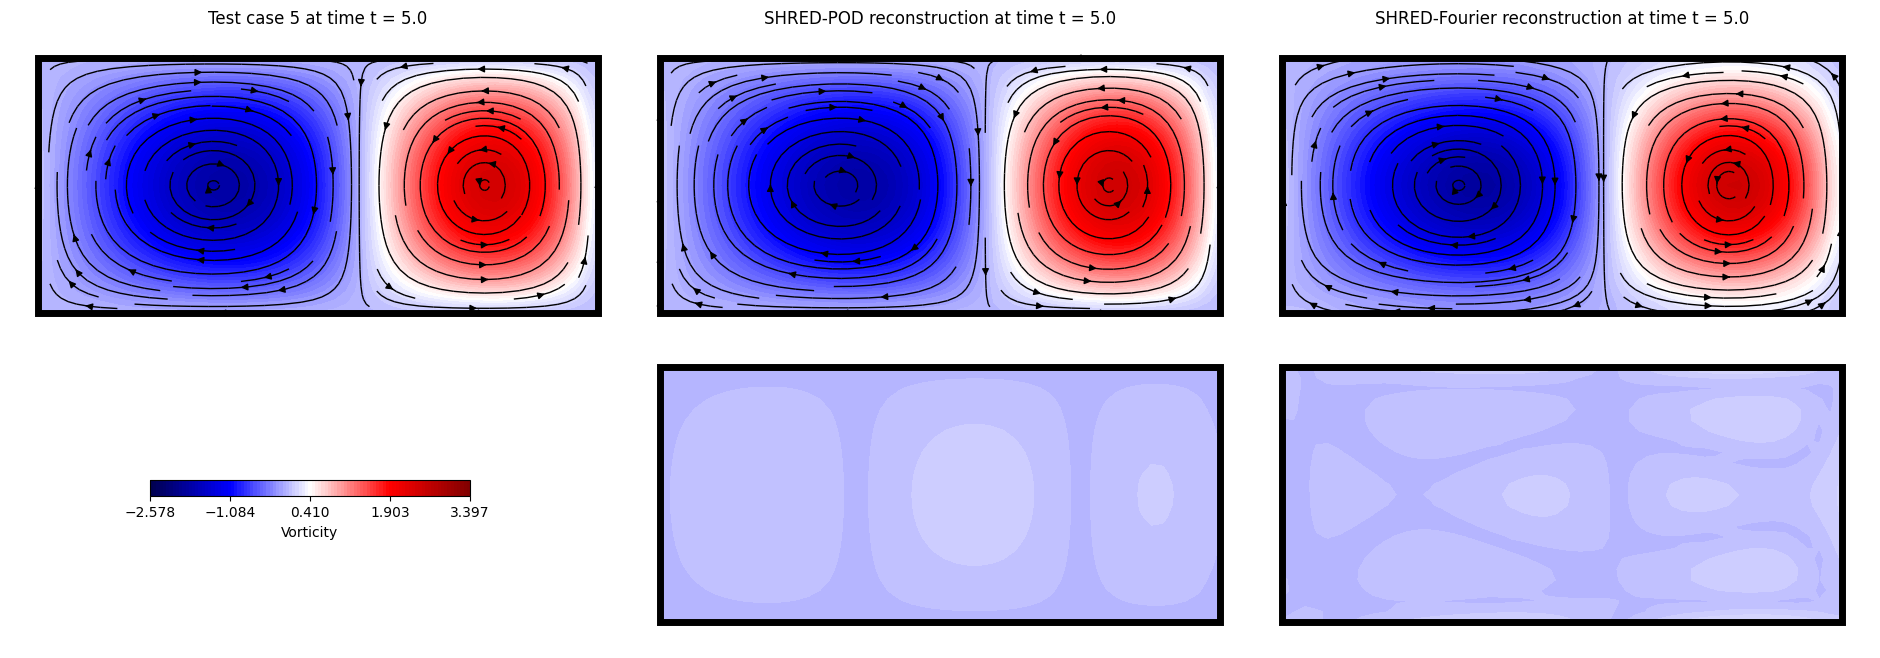

In [32]:
def plot_shred_reconstruction(which_test_trajectory, which_time):

    offset = 0.1

    fig, axs = plt.subplots(2, 3, figsize=(8*3, 8))

    levels = np.linspace(vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).min(),
                         vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).max(),
                         100) * 1.4

    cont = axs[0,0].contourf(x,y, vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = levels)
    axs[0,0].streamplot(x, y, Utest[which_test_trajectory, which_time].T, Vtest[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)

    axs[0,1].contourf(x, y, vorticity(pod_test_reconstruction['U'][which_test_trajectory, which_time], pod_test_reconstruction['V'][which_test_trajectory, which_time]).T, cmap = 'seismic', levels = levels)
    axs[0,1].streamplot(x, y, pod_test_reconstruction['U'][which_test_trajectory, which_time].T, pod_test_reconstruction['V'][which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)

    axs[0,2].contourf(x, y, vorticity(fourier_test_reconstrucion['U'][which_test_trajectory, which_time], fourier_test_reconstrucion['V'][which_test_trajectory, which_time]).T, cmap = 'seismic', levels = levels)
    axs[0,2].streamplot(x, y, fourier_test_reconstrucion['U'][which_test_trajectory, which_time].T, fourier_test_reconstrucion['V'][which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)

    for ax in axs[0]:
        ax.axis('off')
        ax.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
        ax.grid()
        ax.add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    cbar = fig.colorbar(cont, ax=axs[1,0], label='Vorticity', orientation='horizontal', pad=0.04, aspect=20, fraction=0.05)
    cbar.ax.set_xticks(np.linspace(levels.min(), levels.max(), 5))

    axs[1,0].axis('off')
    axs[1,1].contourf(x, y, np.abs(vorticity(pod_test_reconstruction['U'][which_test_trajectory, which_time], pod_test_reconstruction['V'][which_test_trajectory, which_time]).T -
                                   vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T), cmap='seismic', levels=levels)

    axs[1,2].contourf(x, y, np.abs(vorticity(fourier_test_reconstrucion['U'][which_test_trajectory, which_time], fourier_test_reconstrucion['V'][which_test_trajectory, which_time]).T -
                                   vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T), cmap='seismic', levels=levels)

    axs[1,1].axis('off')
    axs[1,2].axis('off')
    axs[1,1].add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    axs[1,2].add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    axs[1,1].axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    axs[1,2].axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])

    axs[0, 0].set_title(f'Test case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    axs[0, 1].set_title(f'SHRED-POD reconstruction at time t = {round(t[which_time], 3)}')
    axs[0, 2].set_title(f'SHRED-Fourier reconstruction at time t = {round(t[which_time], 3)}')

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    cbar.ax.set_position([0.15, 0.3, 0.2, 0.02])

# interact(plot_shred_reconstruction, which_test_trajectory = IntSlider(value = 0, min = 0, max = ntest - 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));
plot_shred_reconstruction(5, 100)